In [8]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
def ngfbfc_processing(df):
    try:
        if "type" in df.columns.to_list():
            df = df.rename(columns={"type": "NGFBFC"}) 

        if 'NGFBFC' in df.columns:
            df['NGFBFC'] = df['NGFBFC'].str.lower()
            df['NGFBFC'] = df['NGFBFC'].replace("oil & palm fruit", "palm oil")
            df['NGFBFC'] = df['NGFBFC'].replace("other non-food & luxury & spices", "non food, luxury, spices")
            df['NGFBFC'] = df['NGFBFC'].replace('other temperate cereals', 'temperate cereals')
        return df
    except Exception as e:
        print(f"error: {e}")
        return df

def region_processing(df):
    try:
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Kazakhstan region', 'Central Asia').replace('C. Europe', 'Central Europe').replace('E. Africa', 'Eastern Africa').replace('N. Africa', 'Northern Africa')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Rest C. America', 'Central America').replace('Rest S. Africa', 'Rest of Southern Africa').replace('Rest S. America', 'Rest of South America')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Rest S. Asia', 'Rest of South Asia').replace('SE. Asia', 'Southeast Asia').replace('Rest S. America', 'Rest of South America')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('W. Africa', 'Western Africa').replace('W. Europe', 'Western Europe').replace('Russia', 'Russia region')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Indonesia', 'Indonesia region').replace('China', 'China region').replace('Korea', 'Korea region')
        return df
    except Exception as e:
        print(f"error: {e}")
        return df

def custom_mean(x):
  """Calculates the mean of non-zero values."""
  non_zero_values = x[x > 0]
  return non_zero_values.sum() / len(non_zero_values) if len(non_zero_values) > 0 else 0

In [3]:
emisi_total = pd.read_excel("D:/kerja/asisten riset/code rev/all_sources_concat_5years_rice.xlsx")
df_ittertols = pd.read_excel("D:/kerja/asisten riset/code v/review/CF_emisi_total_GFRAC_AM1.xlsx")
country_code = pd.read_excel("D:/kerja/asisten riset/vol/milkunC/achaidir/LUH2 2022/ISO-3166-Country-Code_Final.xlsx")
w_factor_intensity =  pd.read_excel("D:/kerja/asisten riset/code v/review/REV_fao_stat_production_mov_average_v2_REGION.xlsx", engine='openpyxl')

In [4]:
start_year = 1975
end_year = 2021

columns = ['IMAGE Region Name', 'time', 'NGFBFC']

In [5]:
emisi_total_copy = emisi_total.copy()
emisi_total_copy = emisi_total_copy.drop(columns=['Unnamed: 0'])
emisi_total_copy = ngfbfc_processing(emisi_total_copy)
emisi_total_copy = emisi_total_copy[emisi_total_copy['NGFBFC'] != "pasture"]
emisi_total_groupby = emisi_total_copy.groupby(['IMAGE Region Name', 'NGFBFC']).sum()
emisi_total_groupby = emisi_total_groupby.reset_index()
emisi_total_groupby = emisi_total_groupby.drop(columns=['emissions', 'category'])

emisi_total_melted = pd.melt(emisi_total_groupby, id_vars=['IMAGE Region Name', 'NGFBFC'], var_name='time', value_name='value')
emisi_total_melted_groupby = emisi_total_melted.groupby(columns).sum()
emisi_total_melted_groupby = emisi_total_melted_groupby.reset_index()
emisi_total_melted_groupby['value'] = emisi_total_melted_groupby['value'] * 1E9

fao_prod_copy = w_factor_intensity.copy()
fao_prod_copy = ngfbfc_processing(fao_prod_copy)
fao_prod_copy = fao_prod_copy[fao_prod_copy['time'] >= start_year]

df_intensity_region = fao_prod_copy.copy()
for region, time, ngfbfc in zip(df_intensity_region["IMAGE Region Name"].to_list(), df_intensity_region["time"].to_list(), df_intensity_region["NGFBFC"].to_list()):
    try:
        data1 = fao_prod_copy[(fao_prod_copy['IMAGE Region Name'] == region) & (fao_prod_copy['time'] == time) & (fao_prod_copy['NGFBFC'] == ngfbfc)]['FAO Production'].to_numpy()
        data2 = emisi_total_melted_groupby[(emisi_total_melted_groupby['IMAGE Region Name'] == region) & (emisi_total_melted_groupby['time'] == time) & (emisi_total_melted_groupby['NGFBFC'] == ngfbfc)]['value'].to_numpy()
        if data1.size == 0:
            data1 = [0]
        if data2.size == 0: 
            data2 = [0]
        mask = df_intensity_region[(df_intensity_region['IMAGE Region Name'] == region) & (df_intensity_region['time'] == time) & (df_intensity_region['NGFBFC'] == ngfbfc)].index
        df_intensity_region.loc[mask, 'Carbon Intensity'] =  data2[0] / data1[0]
    
    except (KeyError, ZeroDivisionError) as e:
        print(f"Error: {e} for region {region}")

df_intensity_region = df_intensity_region.drop(columns=['FAO Production'])
df_intensity_region['Carbon Intensity'] = df_intensity_region['Carbon Intensity'].replace([np.inf, -np.inf], np.nan)
df_intensity_region['Carbon Intensity'] = df_intensity_region['Carbon Intensity'].fillna(0)


In [6]:
df_ittertols = df_ittertols.rename(columns={'type': 'NGFBFC'})
df_ittertols['CF'] = df_ittertols['CF'].replace([np.inf, -np.inf], np.nan)
df_ittertols['CF'] = df_ittertols['CF'].fillna(0)
df_ittertols.loc[df_ittertols['CF'] > 50, 'CF'] = 0
df_ittertols = ngfbfc_processing(df_ittertols)
df_ittertols = df_ittertols.drop(columns=['Unnamed: 0', 'CF'])

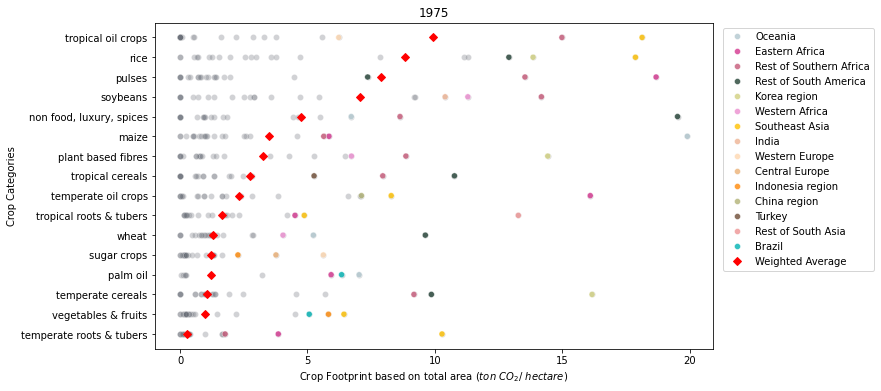

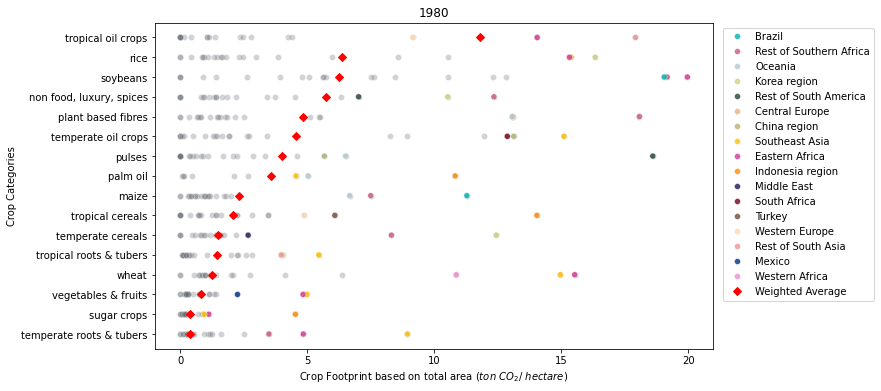

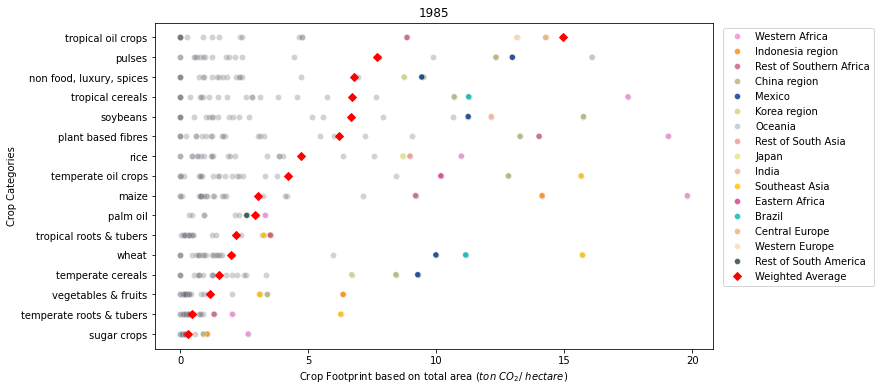

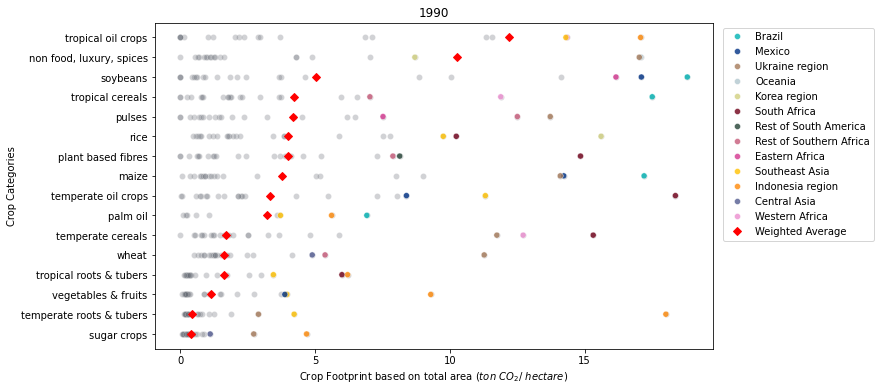

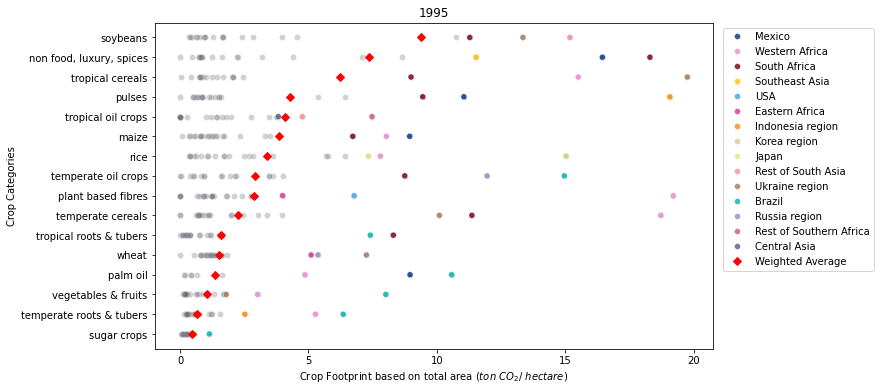

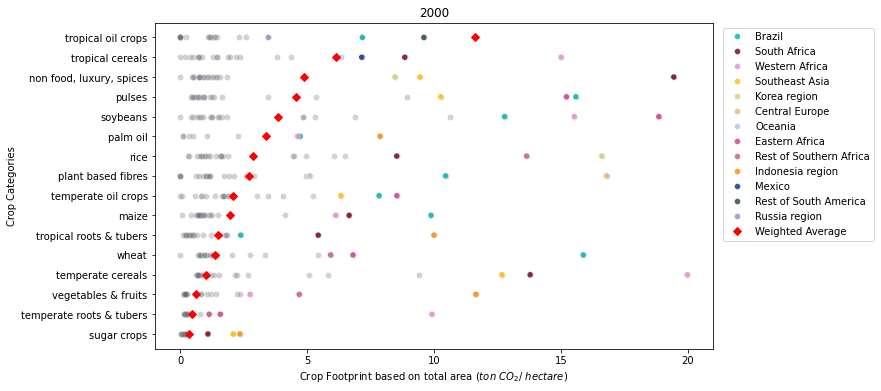

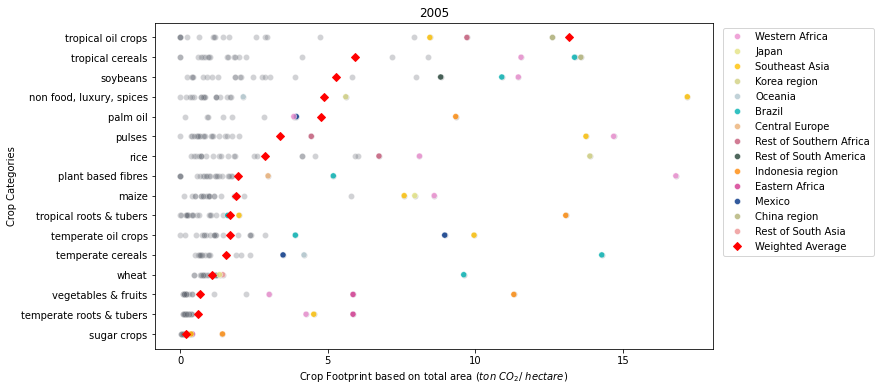

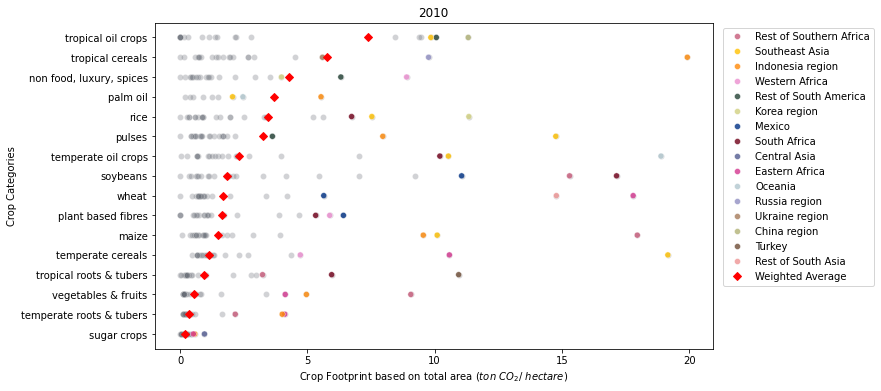

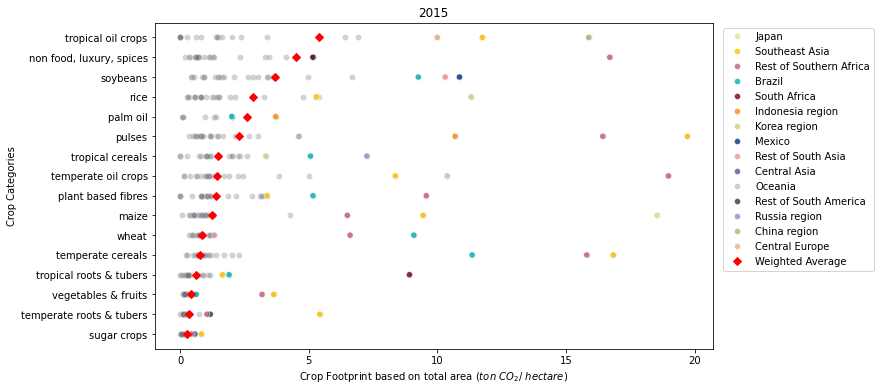

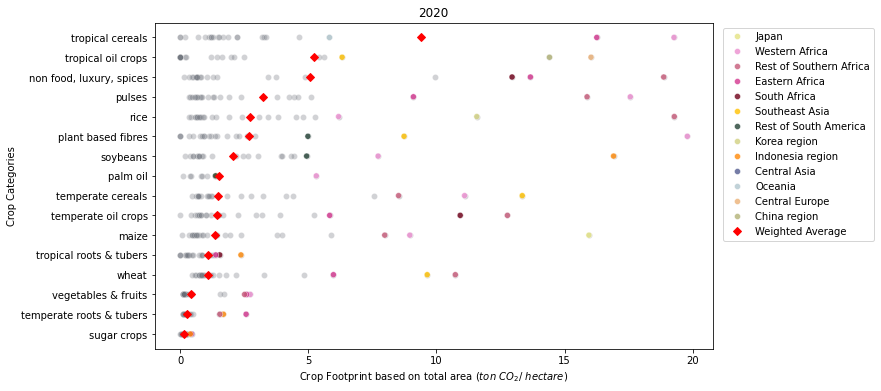

In [9]:
df1_copy = df_intensity_region.copy()
df2_copy = w_factor_intensity.copy()

df1_copy.loc[df1_copy['Carbon Intensity'] > 50, 'Carbon Intensity'] = 0
df1_copy = ngfbfc_processing(df1_copy)
df2_copy = ngfbfc_processing(df2_copy)

df_itertools_copy1 = df_ittertols.copy()
df_itertools_copy1["Carbon Intensity"] = 0.0
df1_copy = df_itertools_copy1.merge(df1_copy , how='left', left_on=columns, right_on=columns)
df1_copy = df1_copy.drop(columns=['Carbon Intensity_x']).rename(columns={"Carbon Intensity_y": "Carbon Intensity"})

df_itertools_copy2 = df_ittertols.copy()
df_itertools_copy2["FAO Production"] = 0.0
df2_copy = df_itertools_copy2.merge(df2_copy , how='left', left_on=columns, right_on=columns)
df2_copy = df2_copy.drop(columns=['FAO Production_x']).rename(columns={"FAO Production_y": "FAO Production"})

data1 = np.zeros((10, 16, 26), dtype='float32')
average_AreaHarvested_RegionCrops = np.zeros((10, 16, 26), dtype='float32')
result_average = np.zeros((16, 10), dtype='float32')

for n, time in enumerate(range(start_year, end_year, 5)):
    for i, ngfbfc in enumerate(df1_copy['NGFBFC'].unique()):
        for j, image_region in enumerate(df2_copy['IMAGE Region Name'].unique()):
            ngfbfc_areaharves = df2_copy[(df2_copy['time'] == time) & (df2_copy['IMAGE Region Name'] == image_region) & (df2_copy['NGFBFC'] == ngfbfc)]['FAO Production'].replace([np.inf, -np.inf], np.nan).values
            average_AreaHarvested_RegionCrops[n][i][j] = np.nan_to_num(ngfbfc_areaharves)

for n, time in enumerate(range(start_year, end_year, 5)):
    for i, ngfbfc in enumerate(df1_copy['NGFBFC'].unique()):
        carbon_footprint = df1_copy[(df1_copy['time'] == time) & (df1_copy['NGFBFC'] == ngfbfc)]['Carbon Intensity'].replace([np.inf, -np.inf], np.nan).values
        data1[n][i] = np.nan_to_num(carbon_footprint)

for i, ngfbfc in enumerate(df1_copy['NGFBFC'].unique()):   
    for n, time in enumerate(range(start_year, end_year, 5)):
        result_average[i][n] = np.average(data1[n][i], weights=average_AreaHarvested_RegionCrops[n][i])

df_avg = pd.DataFrame(result_average, index=[df2_copy['NGFBFC'].unique()], columns=list(range(start_year, end_year, 5)))
df_avg = df_avg.reset_index()
df_avg = df_avg.rename(columns={"level_0":'NGFBFC'})
df_avg_melt = pd.melt(
    df_avg, 
    id_vars=["NGFBFC"], 
    var_name="time",     
    value_name="value"   
)
df_avg = df_avg_melt.sort_values(by=['value', 'NGFBFC'], ascending=[False, False])

results = {}

for category in df_avg['NGFBFC'].unique():
    for time in range(start_year, end_year, 5):
        filtered_data = df_avg[(df_avg['NGFBFC'] == category) & (df_avg['time'] == time)]
        sorted_data = filtered_data.sort_values(by='value', ascending=False)
        top_5_data = sorted_data.head(3)
        if time not in results:
            results[time] = {}
        results[time][category] = top_5_data

df_avg = pd.concat([pd.concat(results[year].values()) for year in results.keys()])
df_avg = df_avg.sort_values(by=['time', 'value'], ascending=[True, False])

df_footprint_region = region_processing(df1_copy)
df_footprint_region_table = pd.pivot_table(data=df_footprint_region, index=['NGFBFC', 'time'], columns=['IMAGE Region Name'])
df_footprint_region_index = df_footprint_region_table.stack(level=0, future_stack=True)
df_footprint_region_index = df_footprint_region_index.reset_index()
df_footprint_region_index_drop = df_footprint_region_index.drop(columns=['level_2'])
df_footprint_region_index_drop.index = df_footprint_region_index_drop['NGFBFC'].values
  
average1_melt = df_footprint_region_index_drop.melt(id_vars=['NGFBFC', 'time'], value_name='value') 
average1_melt = average1_melt[~((average1_melt['IMAGE Region Name'] == "Canada"))]
average1_melt = average1_melt[~((average1_melt['IMAGE Region Name'] == "Central America"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "tropical cereals") & (average1_melt['IMAGE Region Name'] == "Japan"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "palm oil") & (average1_melt['IMAGE Region Name'] == "South Africa"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "palm oil") & (average1_melt['IMAGE Region Name'] == "Rest of Southern Africa"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "palm oil") & (average1_melt['IMAGE Region Name'] == "USA"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "non food, luxury, spices") & (average1_melt['IMAGE Region Name'] == "Russia region"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "soybeans") & (average1_melt['IMAGE Region Name'] == "Southeast Asia"))]

average1_melt.index = average1_melt['NGFBFC'].values
average1_filtered = average1_melt[average1_melt['value'] < 20]

results = {}
average1_new = average1_filtered.sort_values(by=['value', 'NGFBFC'], ascending=[True, True])

for country in average1_new['IMAGE Region Name'].unique():
    for category in average1_new['NGFBFC'].unique():
        for time in range(start_year, end_year, 5):
            filtered_data = average1_new[(average1_new['NGFBFC'] == category) & (average1_new['time'] == time)]
            sorted_data = filtered_data.sort_values(by='value', ascending=False)
            top_5_data = sorted_data.head(3)
            if time not in results:
                results[time] = {}
            results[time][category] = top_5_data

df_footprint_df = pd.concat([pd.concat(results[year].values()) for year in results.keys()])
df_footprint_df_filtered = df_footprint_df[df_footprint_df['value'] < 20]


palettes = {'Oceania': '#B3C8CF','Japan':'#E5E483','Korea region':'#D2D180','China region':'#B2B377','Rest of South Asia':'#EF9595',
                'India':'#EFB495','Indonesia region':'#FF8A08','Southeast Asia':'#FFC100','Middle East':'#1B1A55','Central Asia':'#535C91',
                'Russia region':'#9290C3','Rest of Southern Africa':'#C75B7A','South Africa':'#710019','Eastern Africa':'#D43790',
                'Western Africa':'#EC8FD0','Northern Africa':'#F2C5E0', 'Turkey':'#6F4E37','Ukraine region':'#A67B5B','Central Europe':'#ECB176',
                'Western Europe':'#FED8B1', 'Rest of South America':'#254336','Brazil':'#00b2b2','Central America':'#B3E2A7','Mexico':'#003285',
                'USA':'#40A2E3','Canada':'#BBE2EC'}

for time in range(start_year, end_year, 5):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Crop Footprint based on total area ($ton~CO_2/~hectare$)')
    ax.set_ylabel('Crop Categories')

    plt.title(f"{time}")
    
    produk_diulang = np.array([item for item in df_avg[df_avg['time'] == time]['NGFBFC'].to_list() for _ in range(1)])

    sns.scatterplot(x="value", y="NGFBFC", color='#686D76', sizes=(100, 300), alpha=.3, data=average1_filtered[average1_filtered['time'] == time].loc[produk_diulang])
    sns.scatterplot(x="value", y="NGFBFC", hue='IMAGE Region Name', sizes=(100, 300), alpha=.8, palette=palettes, data=df_footprint_df_filtered[df_footprint_df_filtered['time'] == time])

    ax.legend(bbox_to_anchor=(1.01, 1), ncol=1, loc='upper left')
    ax.plot(df_avg[df_avg['time'] == time].sort_values(by='value', ascending=False)['value'].to_numpy(), df_avg[df_avg['time'] == time].sort_values(by='value', ascending=False)['NGFBFC'].to_numpy(), "D", color='red', label='Weighted Average')
    legend_handles, legend_labels = ax.get_legend_handles_labels()
    weighted_average_index = legend_labels.index('Weighted Average')
    weighted_average_handle = legend_handles.pop(weighted_average_index)
    weighted_average_label = legend_labels.pop(weighted_average_index)
    legend_handles.append(weighted_average_handle)
    legend_labels.append(weighted_average_label)

    ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.01, 1), ncol=1, loc='upper left')
    ax.xaxis.set_major_locator(MultipleLocator(5))

    plt.show()

C:\Users\HEFRYA~1\AppData\Local\Temp/ipykernel_16356/647695991.py:36: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_footprint_region_index = df_footprint_region_table.stack(level=0)


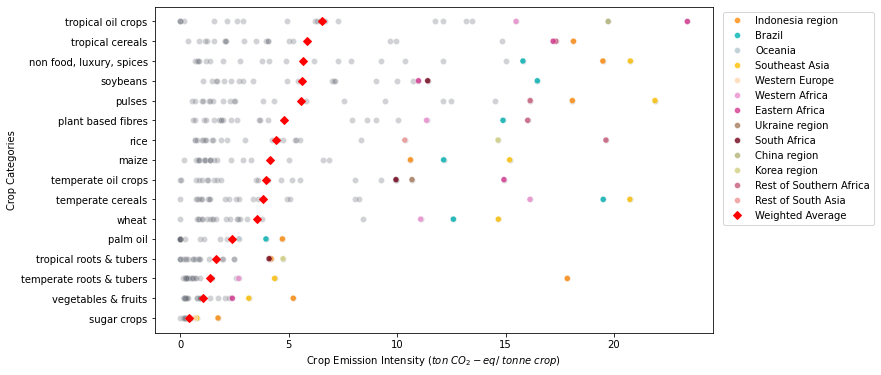

In [10]:

df1_copy = df_intensity_region.copy()
df2_copy  = w_factor_intensity.copy()

df1_copy.loc[df1_copy['Carbon Intensity'] > 50, 'Carbon Intensity'] = 0
df1_copy= ngfbfc_processing(df1_copy)
df2_copy = ngfbfc_processing(df2_copy)

df2_copy = df2_copy[~((df2_copy['time'] <= 1990) & (df2_copy['IMAGE Region Name'] == "Russia"))]
df2_copy = df2_copy[df2_copy['time'] >= start_year]

data1 = np.zeros((16, 26), dtype='float32')
average_AreaHarvested_RegionCrops = np.zeros((16, 26), dtype='float32')
result_average = np.zeros((16), dtype='float32')

for i, ngfbfc in enumerate(df1_copy['NGFBFC'].unique()):
    for n, image_region in enumerate(df2_copy['IMAGE Region Name'].unique()):
        ngfbfc_areaharves = df2_copy[(df2_copy['IMAGE Region Name'] == image_region) & (df2_copy['NGFBFC'] == ngfbfc) & (df2_copy['FAO Production'] > 0)]['FAO Production'].replace([np.inf, -np.inf], np.nan).mean()
        average_AreaHarvested_RegionCrops[i][n] = np.nan_to_num(ngfbfc_areaharves)

for i, ngfbfc in enumerate(df1_copy['NGFBFC'].unique()):
    carbon_footprint = df1_copy[df1_copy['NGFBFC'] == ngfbfc]['Carbon Intensity'].replace([np.inf, -np.inf], np.nan).mean()
    data1[i] = np.nan_to_num(carbon_footprint)

for i, ngfbfc in enumerate(df1_copy['NGFBFC'].unique()):   
    result_average[i] = np.average(data1[i], weights=average_AreaHarvested_RegionCrops[i])
    
df_avg = pd.DataFrame(result_average, index=df2_copy['NGFBFC'].unique())
df_avg = df_avg.reset_index()
df_avg = df_avg.rename(columns={"index":'NGFBFC', 0:"value"})
df_avg = df_avg.sort_values(by=['value'], ascending=[False])

df_footprint_region = region_processing(df1_copy)
df_footprint_region = df_footprint_region[~((df_footprint_region['time'] <= 1990) & (df_footprint_region['IMAGE Region Name'] == "Russia"))] 

df_footprint_region_table = pd.pivot_table(data=df_footprint_region, index=['NGFBFC', 'time'], columns=['IMAGE Region Name'])
df_footprint_region_index = df_footprint_region_table.stack(level=0, future_stack=True)
df_footprint_region_index = df_footprint_region_index.reset_index()
df_footprint_region_index = df_footprint_region_index.drop(columns=['level_2'])
df_footprint_region_index.index = df_footprint_region_index['NGFBFC'].values

produk_diulang = np.array([item for item in df_avg['NGFBFC'].to_list() for _ in range(1)])
df_footprint_region_index = df_footprint_region_index.loc[produk_diulang]
df_footprint_region_index = df_footprint_region_index.drop(columns=['time'])

average1_melt = df_footprint_region_index.melt(id_vars=['NGFBFC'], value_name='value') 
average1_melt['value'] = average1_melt['value'].fillna(0)

average = average1_melt.groupby(['IMAGE Region Name', 'NGFBFC'])['value'].apply(custom_mean).to_frame('Mean').reset_index()

average.index = average['NGFBFC'].values
average_filtered = average[average['Mean'] < 25]

results = {}
average1_new = average_filtered.sort_values(by=['Mean', 'NGFBFC'], ascending=[True, True])

average1_new = average1_new[~((average1_new['IMAGE Region Name'] == "Canada"))]
average1_new = average1_new[~((average1_new['IMAGE Region Name'] == "Central America"))]
average1_new = average1_new[~((average1_new['IMAGE Region Name'] == "Japan"))]
average1_new = average1_new[~((average1_new['IMAGE Region Name'] == "Central Europe"))]
average1_new = average1_new[~((average1_new['NGFBFC'] == "palm oil") & (average1_new['IMAGE Region Name'] == "South Africa"))]
average1_new = average1_new[~((average1_new['NGFBFC'] == "palm oil") & (average1_new['IMAGE Region Name'] == "Rest of Southern Africa"))]
average1_new = average1_new[~((average1_new['NGFBFC'] == "palm oil") & (average1_new['IMAGE Region Name'] == "USA"))]
average1_new = average1_new[~((average1_new['NGFBFC'] == "non food, luxury, spices") & (average1_new['IMAGE Region Name'] == "Russia region"))]
average1_new = average1_new[~((average1_new['NGFBFC'] == "soybeans") & (average1_new['IMAGE Region Name'] == "Southeast Asia"))]
average1_new = average1_new[~((average1_new['NGFBFC'] == "soybeans") & (average1_new['IMAGE Region Name'] == "Indonesia region"))]
average1_new = average1_new[~((average1_new['NGFBFC'] == "plant based fibres") & (average1_new['IMAGE Region Name'] == "Ukraine region"))]

for country in average1_new['IMAGE Region Name'].unique():
    for category in average1_new['NGFBFC'].unique():
        filtered_data = average1_new[average1_new['NGFBFC'] == category]
        sorted_data = filtered_data.sort_values(by='Mean', ascending=False)
        top_5_data = sorted_data.head(3)
        results[category] = top_5_data

df_footprint_df = pd.concat([pd.concat(results.values())])

df_footprint_df_filtered = df_footprint_df[df_footprint_df['Mean'] < 25]


fig, ax = plt.subplots(figsize=(10, 6))

palettes = {'Oceania': '#B3C8CF','Japan':'#E5E483','Korea region':'#D2D180','China region':'#B2B377','Rest of South Asia':'#EF9595',
                'India':'#EFB495','Indonesia region':'#FF8A08','Southeast Asia':'#FFC100','Middle East':'#1B1A55','Central Asia':'#535C91',
                'Russia region':'#9290C3','Rest of Southern Africa':'#C75B7A','South Africa':'#710019','Eastern Africa':'#D43790',
                'Western Africa':'#EC8FD0','Northern Africa':'#F2C5E0', 'Turkey':'#6F4E37','Ukraine region':'#A67B5B','Central Europe':'#ECB176',
                'Western Europe':'#FED8B1', 'Rest of South America':'#254336','Brazil':'#00b2b2','Central America':'#B3E2A7','Mexico':'#003285',
                'USA':'#40A2E3','Canada':'#BBE2EC'}

ax.set_xlabel('Crop Emission Intensity ($ton~CO_2-eq/~tonne~crop$)')
ax.set_ylabel('Crop Categories')

sns.scatterplot(x="Mean", y="NGFBFC", color='#686D76', sizes=(100, 300), alpha=.3, data=average1_new.loc[produk_diulang])
sns.scatterplot(x="Mean", y="NGFBFC", hue='IMAGE Region Name', sizes=(100, 300), alpha=.8, palette=palettes, data=df_footprint_df_filtered)

ax.legend(bbox_to_anchor=(1.01, 1), ncol=1, loc='upper left')
ax.plot(df_avg['value'].to_numpy(), df_avg['NGFBFC'].to_numpy(), "D", color='red', label='Weighted Average')

legend_handles, legend_labels = ax.get_legend_handles_labels()
weighted_average_index = legend_labels.index('Weighted Average')
weighted_average_handle = legend_handles.pop(weighted_average_index)
weighted_average_label = legend_labels.pop(weighted_average_index)
legend_handles.append(weighted_average_handle)
legend_labels.append(weighted_average_label)

ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.01, 1), ncol=1, loc='upper left')

plt.show()